In [1]:
import anndata
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import scanpy.plotting as spl
import sklearn.metrics as sklm
import os

In [2]:
DATA_ROOT_DIR = "data/"
DATA_NAME = "covid_lung"

In [31]:
directory_full_path = DATA_ROOT_DIR + DATA_NAME

anndatas = {}
cell_type_counter = {}
cell_type_dataset_counter = {}
all_cell_types = []
cell_counter = 0

for filename in os.listdir(directory_full_path):
    full_file_path = os.path.join(directory_full_path, filename)
    
    if "restricted" in filename:
        print(f"Skipping reading {full_file_path}")
        continue
    
    print(f"Reading {full_file_path}")
    dataset_anndata = anndata.read_h5ad(full_file_path)
    anndatas[filename] = dataset_anndata
    print(dataset_anndata)
    
    if "BroadCellType" in dataset_anndata.obs.keys():
        cell_type_count = dataset_anndata.obs["BroadCellType"].value_counts().to_dict()
    elif "broad_celltype" in dataset_anndata.obs.keys():
        cell_type_count = dataset_anndata.obs["broad_celltype"].value_counts().to_dict()
    else:
        cell_type_count = dataset_anndata.obs["CellType"].value_counts().to_dict()
    for cell_type_name, count in cell_type_count.items():
        cell_type_name = cell_type_name.lower()
        all_cell_types.append(cell_type_name)
        if cell_type_name in cell_type_counter.keys():
            cell_type_counter[cell_type_name] += count
        else:
            cell_type_counter[cell_type_name] = count
            
        if cell_type_name in cell_type_dataset_counter.keys():
            cell_type_dataset_counter[cell_type_name].append(filename)
        else:
            cell_type_dataset_counter[cell_type_name] = [filename]
            
    cell_counter += dataset_anndata.X.shape[0]
            
print()
print(cell_type_counter)
print()
print(f"Number of cell types total : {len(all_cell_types)}. Which are : {all_cell_types}")
print()
print(f"Total number of unique cell types : {len(cell_type_counter.keys())}")
print()
print(f"Total number of cells: {cell_counter}")
print()
for cell_type, datasets in cell_type_dataset_counter.items():
    print(f"{cell_type} : {datasets}")

Skipping reading data/covid_lung/deprez19_restricted.processed.h5ad
Reading data/covid_lung/lukassen20_lung_orig.processed.h5ad
AnnData object with n_obs × n_vars = 39778 × 32738 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sex', 'age', 'smoking', 'packyears', 'percent.mito', 'CellType'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
Reading data/covid_lung/vieira19_Nasal_anonymised.processed.h5ad
AnnData object with n_obs × n_vars = 7087 × 33694 
    obs: 'Sample', 'Donor', 'Source', 'Location', 'CellType', 'BroadCellType'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'neighbors_hm', 'pca'
    obsm: 'X_umap_hm'
    varm: 'PCs'
Reading data/covid_lung/lukassen20_airway_orig.processed.h5ad
AnnData object with n_obs × n_vars = 17451 × 22100 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'CellType', 'sex', 'age', 'smoking'
    var: 'name'
    obsm: 'X_umap'
Reading data/covid_lung/vieira19_Bronchi_anonymised.

In [33]:
# Concatenate the anndata objects
only_anndatas = list(anndatas.values())
concatenated_anndatas = only_anndatas[0].concatenate(only_anndatas[1], only_anndatas[2], only_anndatas[3], only_anndatas[4], batch_categories=list(anndatas.keys()))
print(concatenated_anndatas)

AnnData object with n_obs × n_vars = 94160 × 20755 
    obs: 'BroadCellType', 'CellType', 'Donor', 'Location', 'Sample', 'Source', 'age', 'batch', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'packyears', 'percent.mito', 'percent.mt', 'sample', 'sex', 'smoking'
    var: 'name-lukassen20_lung_orig.processed.h5ad', 'highly_variable-vieira19_Nasal_anonymised.processed.h5ad', 'means-vieira19_Nasal_anonymised.processed.h5ad', 'dispersions-vieira19_Nasal_anonymised.processed.h5ad', 'dispersions_norm-vieira19_Nasal_anonymised.processed.h5ad', 'name-lukassen20_airway_orig.processed.h5ad', 'highly_variable-vieira19_Bronchi_anonymised.processed.h5ad', 'means-vieira19_Bronchi_anonymised.processed.h5ad', 'dispersions-vieira19_Bronchi_anonymised.processed.h5ad', 'dispersions_norm-vieira19_Bronchi_anonymised.processed.h5ad', 'highly_variable-vieira19_Alveoli_and_parenchyma_anonymised.processed.h5ad', 'means-vieira19_Alveoli_and_parenchyma_anonymised.processed.h5ad', 'dispersions-vieira19_Alveoli_and_

In [34]:
# Concatenate UMAP embeddings
obsm = None
expected_number_of_cells = 0

for index, dataset in enumerate(anndatas.items()):
    dataset_anndata = dataset[1]
    if "X_umap_hm" in dataset_anndata.obsm.keys():
        umap = dataset_anndata.obsm["X_umap_hm"]
    elif "X_umap" in dataset_anndata.obsm.keys():
        umap = dataset_anndata.obsm["X_umap"]
        
    expected_number_of_cells += umap.shape[0]
    
    if index == 0:
        obsm = umap
    else:
        obsm = np.concatenate((obsm, umap), axis=0)
        
print(f"Expected number of cells {expected_number_of_cells}")
print(obsm.shape)

concatenated_anndatas.obsm["X_umap"] = obsm
print(concatenated_anndatas)

Expected number of cells 94160
(94160, 2)
AnnData object with n_obs × n_vars = 94160 × 20755 
    obs: 'BroadCellType', 'CellType', 'Donor', 'Location', 'Sample', 'Source', 'age', 'batch', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'packyears', 'percent.mito', 'percent.mt', 'sample', 'sex', 'smoking'
    var: 'name-lukassen20_lung_orig.processed.h5ad', 'highly_variable-vieira19_Nasal_anonymised.processed.h5ad', 'means-vieira19_Nasal_anonymised.processed.h5ad', 'dispersions-vieira19_Nasal_anonymised.processed.h5ad', 'dispersions_norm-vieira19_Nasal_anonymised.processed.h5ad', 'name-lukassen20_airway_orig.processed.h5ad', 'highly_variable-vieira19_Bronchi_anonymised.processed.h5ad', 'means-vieira19_Bronchi_anonymised.processed.h5ad', 'dispersions-vieira19_Bronchi_anonymised.processed.h5ad', 'dispersions_norm-vieira19_Bronchi_anonymised.processed.h5ad', 'highly_variable-vieira19_Alveoli_and_parenchyma_anonymised.processed.h5ad', 'means-vieira19_Alveoli_and_parenchyma_anonymised.processed

... storing 'BroadCellType' as categorical
... storing 'CellType' as categorical
... storing 'Donor' as categorical
... storing 'Location' as categorical
... storing 'Sample' as categorical
... storing 'Source' as categorical
... storing 'orig.ident' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'smoking' as categorical
/Users/arathimani/CZI/cell2vec/venv37/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


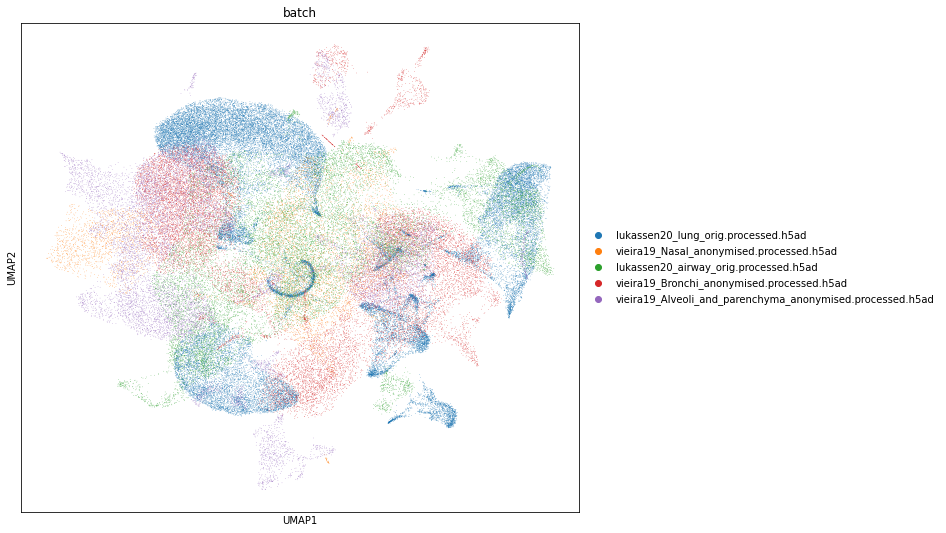

In [35]:
# Plot the cells using UMAP, colored by the dataset from which it came. Vector is their gene expressions.
fig, ax = plt.subplots(figsize=(10, 9))
spl.umap(concatenated_anndatas, color=["batch"], ax=ax, show=True)

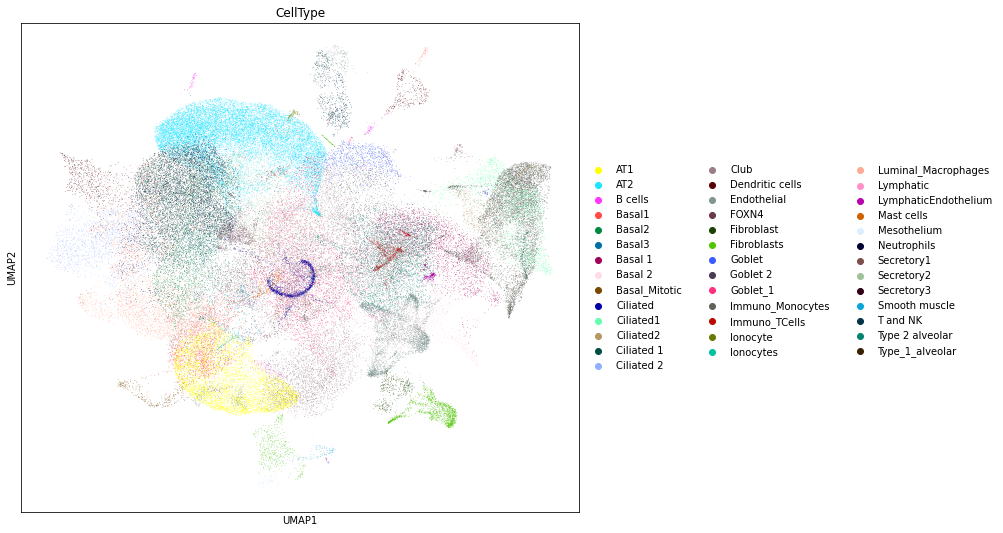

In [36]:
# Plot the cells using UMAP, colored by the dataset from which it came. Vector is their gene expressions.
fig, ax = plt.subplots(figsize=(10, 9))
spl.umap(concatenated_anndatas, color=["CellType"], ax=ax, show=True)

In [47]:
# Canonicalize cell types a bit
canonical_cell_types = ["AT", "BASAL", "CILIATED", "FIBROBLAST", "GOBLET", "IONOCYTE", "SECRETORY"]

original_cell_types = concatenated_anndatas.obs["CellType"]

def canonicalize(x):
    x = x.upper()
    for canonical_cell_type in canonical_cell_types:
        if canonical_cell_type in x:
            return canonical_cell_type
    return x

concatenated_anndatas.obs["CanonicalCellType"] = original_cell_types.map(canonicalize)

... storing 'CanonicalCellType' as categorical
/Users/arathimani/CZI/cell2vec/venv37/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


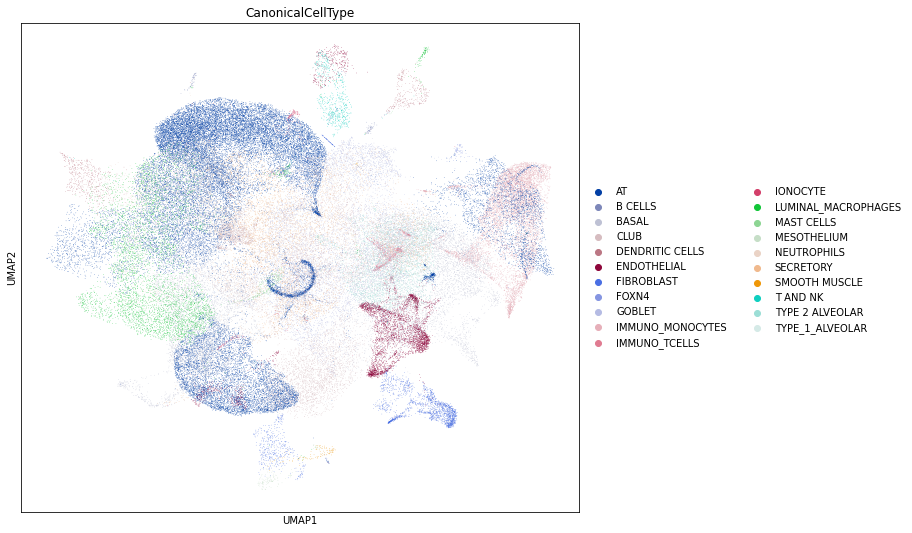

In [57]:
fig, ax = plt.subplots(figsize=(10, 9))
spl.umap(concatenated_anndatas, color=["CanonicalCellType"], ax=ax, show=True)

In [49]:
def compute_silhouette_coefficient(anndata, obsm_key, label_key, sample_size):
    embeddings = anndata.obsm.get(obsm_key)
    labels = anndata.obs.get(label_key)
    return sklm.silhouette_score(embeddings, labels, sample_size=sample_size)
    
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CellType", 10000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CellType", 20000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CellType", 30000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CellType", 40000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CanonicalCellType", 10000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CanonicalCellType", 20000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CanonicalCellType", 30000))
print(compute_silhouette_coefficient(concatenated_anndatas, "X_umap", "CanonicalCellType", 40000))

-0.16931500643286648
-0.15524039376559975
-0.15878681784524024
-0.16361490363649006
-0.29300679161626214
-0.30603584099791703
-0.31411455843586655
-0.30747312732312093


In [50]:
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE

In [51]:
concatenated_anndatas.obs["batch_index"] = concatenated_anndatas.obs['batch'].cat.codes

scvi_anndataset = AnnDatasetFromAnnData(concatenated_anndatas, batch_label="batch_index", ctype_label="CanonicalCellType")

[2020-04-10 15:25:37,820] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-10 15:25:37,826] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-10 15:25:42,118] WARNING - scvi.dataset.dataset | X contains continuous and/or negative values. Please use raw UMI/read counts with scVI
[2020-04-10 15:25:42,119] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-10 15:25:44,798] INFO - scvi.dataset.dataset | Downsampled from 94160 to 94160 cells


In [56]:
print(scvi_anndataset.nb_genes)
print(scvi_anndataset.n_batches)
print(scvi_anndataset.n_labels)

20755
5
21


In [59]:
# scVI Parameters
train_size = 0.9
use_cuda = True
frequency = 5
num_epochs = 10
learning_rate = 1e-3

In [60]:
vae = VAE(
    n_input=scvi_anndataset.nb_genes, 
    n_batch=scvi_anndataset.n_batches, 
    n_labels=scvi_anndataset.n_labels, 
    dispersion="gene-batch",
    reconstruction_loss="nb"
)
trainer = UnsupervisedTrainer(vae, scvi_anndataset, train_size=train_size, use_cuda=use_cuda, frequency=frequency)

In [61]:
trainer.train(n_epochs=num_epochs, lr=learning_rate)

/Users/arathimani/CZI/cell2vec/venv37/lib/python3.7/site-packages/scvi/models/distributions.py:116: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


KeyboardInterrupt: 